# Project 1: Gradient-based Algorithms and Differentiable Programming


## 1. Introduction
Consider a simple formulation of rocket landing where the rocket state $x(t)$ is represented by its distance to the ground $d(t)$ and its velocity $v(t)$, i.e., $x(t) = [d(t), v(t)]^T$, where $t$ specifies time. The control input of the rocket is its acceleration $a(t)$. The discrete-time dynamics follows 

$$
\begin{aligned}
d(t+1) = d(t) + v(t) \Delta t, \\
v(t+1) = v(t) + a(t) \Delta t,
\end{aligned}
$$

where $\Delta t$ is a time interval. Further, let the closed-loop controller be 

$$
a(t) = f_{\theta}(x(t))
$$

where $f_{\theta}(\cdot)$ is a neural network with parameters $\theta$, which are to be determined through optimization.

For each time step, we assign a loss as a function of the control input and the state: $l(x(t),a(t))$. In this example, we will simply set $l(x(t),a(t))=0$ for all $t=1,...,T-1$, where $T$ is the final time step, and $l(x(T),a(T)) = ||x(T)||^2 = d(T)^2 + v(T)^2$. This loss encourages the rocket to reach $d(T)=0$ and $v(T)=0$, which are proper landing conditions.

The optimization problem is now formulated as

$$
\begin{aligned}
\min_{\theta} \quad & ||x(T)||^2 \\
\quad & d(t+1) = d(t) + v(t) \Delta t, \\
\quad & v(t+1) = v(t) + a(t) \Delta t, \\
\quad & a(t) = f_{\theta}(x(t)), ~\forall t=1,...,T-1
\end{aligned}
$$

While this problem is constrained, it is easy to see that the objective function can be expressed as a function of $x(T-1) and a(T-1)$, where $x(T-1)$ as a function of $x(T-2)$ and $a(T-2)$, and so on. Thus it is essentially an unconstrained problem with respect to $\theta$. 

In the following, we code this problem up with [PyTorch](https://pytorch.org/), which allows us to only build the forward pass of the loss (i.e., how we move from $x(1)$ to $x(2)$ and all the way to $x(T)$) and automatically get the gradient $\nabla_{\theta} l(x(T),a(T))$.

---

## 2. A Better Problem Formulation

Here is a list of things we discussed during the class that could help to make the problem more representative of the reality:

1. More realistic definition of state and action spaces: Rocket orientation, angular velocity, etc. 
2. Better dynamical model, e.g., drag
3. Constraints in state and action spaces
4. Controller design for a distribution of initial states rather than one
5. Randomness in dynamics, sensing, etc.
6. Discontinuity in modeling so that gradient cannot be computed, e.g., mechanical failures.

In this project, please choose at least one aspect from 1 to 5 from the list to improve your problem formulation and solve the resultant problem. We will address 6 when we talk about reinforcement learning.

Here is one example of problem formulation when we consider randomness in dynamics and initial states:

$$
\begin{aligned}
\min_{\theta} \quad & \mathbb{E}_{\{w(t), u(t), x(0)\}}\left[||x(T)||^2\right] \\
\quad & d(t+1) = d(t) + v(t) + w(t) \Delta t, \\
\quad & v(t+1) = v(t) + a(t) + u(t) \Delta t, \\
\quad & a(t) = f_{\theta}(x(t)), ~\forall t=1,...,T-1 \\
\quad & x(1) \sim \Pr(x(1))
\end{aligned}
$$

Here $w(t) \sim \Pr(w(t))$ and $u(t) \sim \Pr(u(t))$ are modeled as i.i.d. noises added to the dynamics, and $\Pr(x(1))$ is the distribution of initial states. We will approximate this problem using samples from $\Pr(w(t))$, $\Pr(u(t))$, and $\Pr(x(1))$. To do so, we sample $\{w(1)^{(i)},w(2)^{(i)},...,w(T)^{(i)}\}_{i}^N$ from $\Pr(w(t))$,  $\{u(1)^{(i)},u(2)^{(i)},...,u(T)^{(i)}\}_{i}^N$ from $\Pr(u(t))$, and $\{x(0)^{(i)}\}_{i}^N$ from $\Pr(x(1))$, where $N$ is the number of samples to be considered. Then we have the following problem instead:

$$
\begin{aligned}
\min_{\theta} \quad & \frac{1}{N}\sum_{i=1}^N ||x^{(i)}(T)||^2 \\
\quad & d(t+1)^{(i)} = d(t)^{(i)} + v(t)^{(i)} + w(t)^{(i)} \Delta t, \\
\quad & v(t+1)^{(i)} = v(t)^{(i)} + a(t)^{(i)} + u(t)^{(i)} \Delta t, \\
\quad & a(t)^{(i)} = f_{\theta}(x(t)^{(i)}), ~\forall t=1,...,T-1, ~i=1,...,N \\
\end{aligned}
$$

The code up this new problem, you will fully utilize the tensor operations in PyTorch. For example, the state tensor "x" will now become a N-by-2 matrix, where the first dimension represents the number of trajectories to be optimized. 

## 3. Grading

* (30%) Documentation of the problem formulation: Clearly describe the objective function, the variables, the constraints, and the assumptions involved in formulating the problem.

* (40%) Programming: Like for homeworks, please push you code to your github repo. Please comment your code so that it is useful to you in the future.

* (30%) Analysis of the results: Please document the convergence and the optimal solutions (e.g., the state trajectory if it is a control problem).

* (Bonus 20%) Formulation of a problem different from rocket landing: The PyTorch framework can also be used for other engineering problems, e.g., for structure design with nonlinear mechanical properties. You get 20 bonus points for solving your own problems that are at least at the same level of difficulty as rocket landing. 

In [141]:
"""Optimization of a Controller for rocket landing with Neural Networks."""

import numpy as np
import torch as t
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
import seaborn as sns


class Controller(nn.Module):
    """NN Controller for rocket landing."""
    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        Inputs:
          - dim_input(int):  # of system states
          - dim_output(int): # of actions
          - dim_hidden(int): # of hidden layer nodes
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid())

    def forward(self, state):
        """Forward propagation.

        Inputs:
          - state(torch.Tensor):  The system state of size [dim_input,]
        Returns:
          - action(torch.Tensor): The action to take of size [dim_output,]
        """
        action = self.network(state)
        return action


class Rocket():
    def __init__(self, controller, T):
        """Inputs:
          - controller(class): The rocket controller
          - T(int):            Number of simulation time steps
        """
        self.init_state = self.initialize_state()
        self.controller = controller
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []
        self.beta = 0.3  # Drag coefficient

    @staticmethod
    def initialize_state():
        state = [1., 0.]
        return t.tensor(state, requires_grad=False).float()

    def dynamics(self, state, action):
        """Rocket dynamics.

        Inputs:
          - state(torch.Tensor):  The state of the system
                                  state[0] = y, state[1] = y_dot
          - action(torch.Tensor): Amount of Thrust
        Returns:
          - state(torch.Tensor):  The state of the system at the next time step, after taking the action
        """

        A = t.tensor([[1., FRAME_TIME-1/2*self.beta*FRAME_TIME**2],
                      [0., 1-self.beta*FRAME_TIME]])
        B = t.tensor([-1/2*FRAME_TIME**2, -FRAME_TIME])
        U = BOOST_ACCEL*action                     # Thrust
        G = t.tensor([1/2*FRAME_TIME**2, FRAME_TIME])*GRAVITY_ACCEL
        state = t.matmul(A, state) + B*U + G       # X[t+1] = AX[t] + BU[t] + G
        return state

    def simulate_path(self, state):
        """Rocket path simulation.

        Inputs:
          - state(torch.Tensor):  The initial state of the system
        Returns:
          - state(torch.Tensor):  The state of the system at the last time step
        """
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller(state)
            state = self.dynamics(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return state  # Final state of rocket


class Optimize:
    """Optimizer that trains the Controller."""
    def __init__(self, rocket):
        self.rocket = rocket
        self.parameters = rocket.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)
        # self.optimizer = optim.Adagrad(self.parameters, lr=0.65)
        self.eps = 1e-7  # Loss value threshold to stop training
        self.loss_history = []

    def loss_fun(self, state):
        """The loss function

        Inputs:
          - state(torch.Tensor):  The final state of the system
        """
        return state[0]**2 + state[1]**2

    def train(self, network, epochs):
        """Trains the model/controller.

        Inputs:
          - network(class): The controller
          - epochs(int):    The number of training iterations
        """

        network.train()  # Set the module in training mode (only affects certain modules)
        epoch = 0
        loss = float('inf')

        while loss > self.eps and epoch < epochs:

            def closure():
                """A closure that reevaluates the model and returns the loss.
                Needed for some optimizers like LBFGS. """
                self.optimizer.zero_grad()                                  # Clear gradients
                final_state = self.rocket.simulate_path(self.rocket.init_state)  # Compute final state
                loss = self.loss_fun(final_state)                           # Compute loss
                loss.backward()                                             # Compute gradients
                return loss

            self.optimizer.step(closure)                                    # Update weights
            loss = closure()                                                # Compute loss

            epoch += 1
            self.loss_history.append(loss)
            print('Epoch: {} \t Loss: {:.6}'.format(epoch, loss))
            print('Final state: {}'.format(self.rocket.simulate_path(self.rocket.init_state).detach().numpy()))
            self.visualize()

    def visualize(self):
        """Plots rocket path and trajectories."""

        data = np.array([self.rocket.state_trajectory[i].detach().numpy() for i in range(self.rocket.T)])
        x = data[:, 0]  # Distance from ground
        v = data[:, 1]  # Velocity

        sns.set_theme()
        fig = plt.figure(figsize=(20, 6))
        
        # Distance vs Velocity
        ax = fig.add_subplot(1, 3, 1)
        ax.plot(x, v)
        ax.plot(x[0], v[0], 'o', label='initial state')
        ax.legend(loc='upper center')
        ax.set_xlabel('Distance from ground')
        ax.set_ylabel('Velocity')
        ax.set_title('State Path')
        
        # Time vs Distance
        ax = fig.add_subplot(1, 3, 2)        
        ax.plot(x)
        ax.plot(0, x[0], 'o', label='initial state')
        ax.legend(loc='upper center')
        ax.set_xlabel('Time')
        ax.set_ylabel('Distance from ground')
        ax.set_title('Rocket Trajectory')
        
        # Time vs Velocity
        ax = fig.add_subplot(1, 3, 3)
        ax.plot(v)
        ax.plot(0, v[0], 'o', label='initial state')
        ax.legend(loc='upper center')
        ax.set_xlabel('Time')
        ax.set_ylabel('Velocity')
        ax.set_title('Rocket Trajectory')
        plt.show()
    
    def plot_loss_history(self):
        """Plot loss vs. iteration """

        sns.set_theme()
        plt.figure()
        plt.plot(self.loss_history)   
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title('Loss vs. iteration')
        plt.show()
        print()
        return
    
    def plot_trajectories(self):
        """Plot final rocket trajectories. """

        data = np.array([self.rocket.state_trajectory[i].detach().numpy() for i in range(self.rocket.T)])
        x = data[:, 0]  # Distance from ground
        v = data[:, 1]  # Velocity

        sns.set_theme()
        fig = plt.figure()

        # Time vs Distance
        ax = fig.add_subplot(2, 1, 1)        
        ax.plot(x)
        ax.plot(0, x[0], 'o', label='initial state')
        ax.legend(loc='lower left')
        ax.set_xlabel('Time')
        ax.set_ylabel('Distance from ground')
        ax.set_title('Rocket Trajectories')
        
        # Time vs Velocity
        ax = fig.add_subplot(2, 1, 2)
        ax.plot(v)
        ax.plot(0, v[0], 'o', label='initial state')
        ax.legend(loc='lower left')
        ax.set_xlabel('Time')
        ax.set_ylabel('Velocity')
        plt.show()

    def show_results(self):
        """Show and Plot optimization results. """

        print('\n'+'-'*60+'\n\t\tOptimizatin Results\n'+'-'*60)
        print('\nNumber of iterations: {}'.format(len(self.loss_history)))
        print('Final loss value: {:.6}'.format(self.loss_history[-1].data.numpy()))
        final_state = self.rocket.state_trajectory[-1].detach().numpy()
        print('The rocket lands with the following conditions:')
        print('\tDistance from ground = {:.4}\n\tVelocity = {:.4}\n'.format(final_state[0], final_state[1]))
        self.plot_loss_history()
        self.plot_trajectories()


if __name__ == "__main__":

    # Environment parameters
    # -------------------------------------------------------------------------
    FRAME_TIME = 0.1                                   # Time interval Dt
    GRAVITY_ACCEL = 0.12                               # Gravity constant
    BOOST_ACCEL = 0.18                                 # Thrust constant

    # Training parameters
    # -------------------------------------------------------------------------
    T = 100                                            # Number of time steps the rocket is simulated
    dim_input = 2                                      # State space dimensions
    dim_hidden = 6                                     # Latent dimensions
    dim_output = 1                                     # Action space dimensions

    # Optimize Rocket Controller
    # -------------------------------------------------------------------------
    c = Controller(dim_input, dim_hidden, dim_output)  # Define controller
    s = Rocket(c, T)                                   # Define rocket simulation
    o = Optimize(s)                                    # Define optimizer
    o.train(c, 100)                                    # Solve the optimization problem

    o.show_results()                                   # Show optimization results


Output hidden; open in https://colab.research.google.com to view.

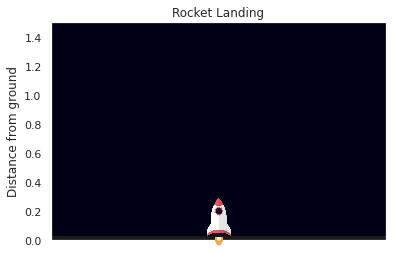

In [124]:
from matplotlib import animation
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg


def animate_landing(): 
    """Create rocket landing animation"""

    def init():
        """Initialization function: plot the background of each frame"""
        ground.set_data([], [])
        return ground, ab_rocket,

    def animate(i):  
        """Animation function.  This is called sequentially""" 
        ground.set_data(x_ground, 0)

        if x[i-1]>0.12:
            ab_rocket.xybox = (0, x[i-1])
        else:
            ab_rocket.xybox = (0, 0.12)

        return ground, ab_rocket,

    # Get rocket path
    data = np.array([s.state_trajectory[i].detach().numpy() for i in range(s.T)])
    x = data[:, 0]  # Distance from ground

    my_rocket = mpimg.imread('rocket.png')

    # First set up the figure, axis and plot elements to be animated
    fig = plt.figure()
    sns.set_style()
    ax = plt.axes(xlim=(-2, 2), ylim=(0, x[0]+0.5))
    ax.set_xticklabels([])
    ax.set_ylabel('Distance from ground')
    ax.title.set_text('Rocket Landing')
    ax.set_facecolor((0., 0., 0.09))
    # Ground
    ground, = ax.plot([], [],'k', lw=8)
    x_ground = np.linspace(-2, 2, 100)
    # Rocket
    imagebox_rocket = OffsetImage(my_rocket, zoom=0.1)
    ab_rocket = AnnotationBbox(imagebox_rocket, (0, x[0]), frameon=False)
    ax.add_artist(ab_rocket)

    plt.grid()
    plt.draw()

    # Call the animator. blit=True means only re-draw the parts that have changed
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                frames=100, interval=20, blit=True)

    # Save the animation as an mp4
    anim.save('rocket_landing.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

    plt.show()

# Create animation and save as mp4
animate_landing()

#### Show animation video

In [128]:
from IPython.display import HTML
from base64 import b64encode
import os

# Input video path
save_path = "rocket_landing.mp4"

# Compressed video path
compressed_path = "rocket_landing_compressed.mp4"

os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)